In [43]:
## The issue for Mac Users...
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [45]:
print(tf.__version__)

2.0.0


In [46]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

dataset_path


'/Users/yesaya.athuman/.keras/datasets/auto-mpg.data'

In [47]:
columns_name = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Accelaration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=columns_name, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelaration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [48]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Accelaration    0
Model Year      0
Origin          0
dtype: int64

In [49]:
dataset = dataset.dropna()


In [50]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [51]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accelaration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [52]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

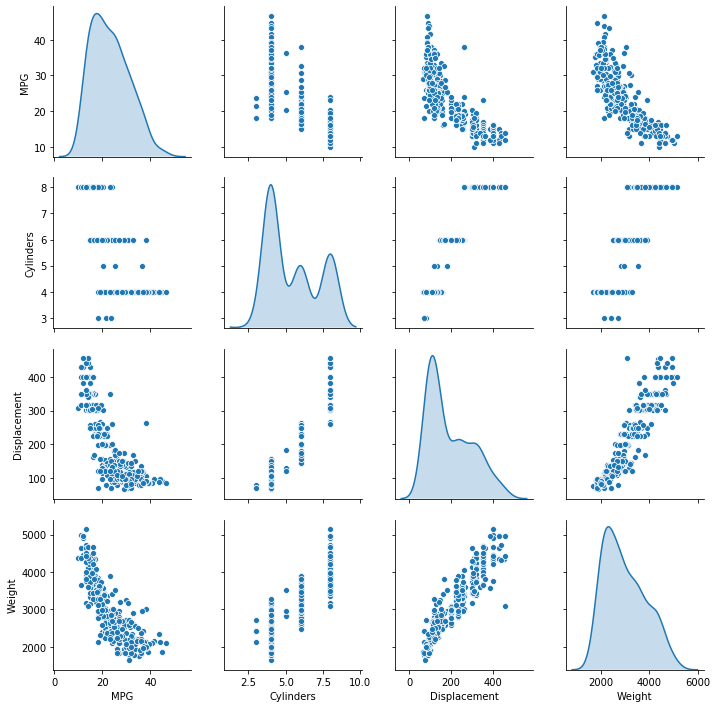

In [53]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [54]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Accelaration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [55]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [56]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [57]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [58]:
model = build_model()

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [60]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.33637944],
       [ 0.38109803],
       [-0.05851513],
       [ 0.3318829 ],
       [ 0.05970244],
       [ 0.21821718],
       [ 0.14667282],
       [ 0.33677322],
       [ 0.158293  ],
       [ 0.19628169]], dtype=float32)

In [61]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:567.4739,  mae:22.5627,  mse:567.4739,  val_loss:559.3044,  val_mae:22.3669,  val_mse:559.3043,  
....................................................................................................
Epoch: 100, loss:5.9431,  mae:1.7343,  mse:5.9431,  val_loss:7.7351,  val_mae:2.1616,  val_mse:7.7351,  
....................................................................................................
Epoch: 200, loss:5.4899,  mae:1.6518,  mse:5.4899,  val_loss:8.4053,  val_mae:2.2625,  val_mse:8.4053,  
....................................................................................................
Epoch: 300, loss:4.7904,  mae:1.5016,  mse:4.7904,  val_loss:8.4189,  val_mae:2.1753,  val_mse:8.4189,  
....................................................................................................
Epoch: 400, loss:4.3388,  mae:1.4189,  mse:4.3388,  val_loss:8.9513,  val_mae:2.2716,  val_mse:8.9513,  
..............................................................

In [62]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.522367,1.045797,2.522366,9.959084,2.322614,9.959085,995
996,2.884300,1.167431,2.884300,9.941394,2.372386,9.941395,996
997,2.566841,1.027799,2.566841,9.745270,2.342218,9.745271,997
998,2.505452,1.031150,2.505452,9.702245,2.379562,9.702246,998
999,2.669669,1.079039,2.669669,9.476229,2.293475,9.476230,999


In [63]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

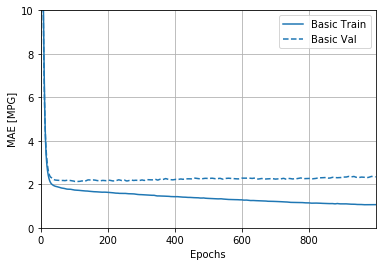

In [64]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

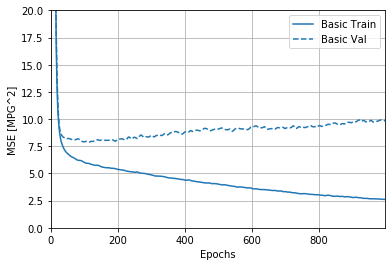

In [65]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [66]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:570.0887,  mae:22.5931,  mse:570.0887,  val_loss:558.6297,  val_mae:22.2866,  val_mse:558.6297,  
.............................................................................

Text(0, 0.5, 'MAE [MPG]')

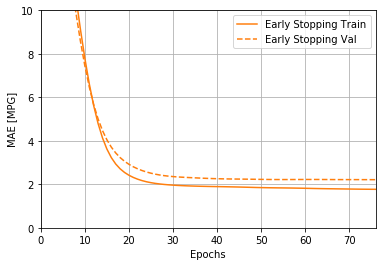

In [67]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [68]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6985 - mae: 1.8053 - mse: 5.6985
Testing set Mean Abs Error:  1.81 MPG


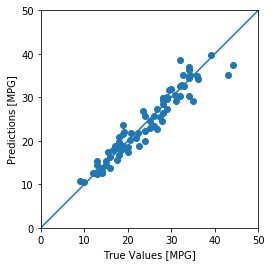

In [69]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

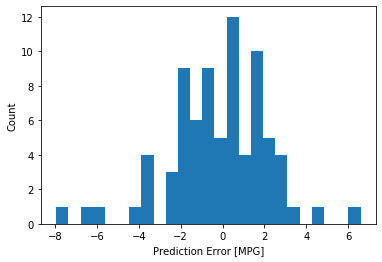

In [70]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")